# Biometric Failure Analysis - UIDAI (Corrected)

**Analyst:** Priya Sharma  
**Objective:** Identify patterns in biometric capture issues and anomalies

## ⚠️ Data Understanding:
- **Demographic data**: New enrollment applications/registrations
- **Biometric data**: Biometric capture attempts (may include retries)
- **Failure Definition**: Locations/periods with unusually low biometric activity

## Analysis Approach:
1. **Temporal Anomaly Detection** - Sudden drops in biometric captures
2. **Geographic Anomaly Detection** - Districts with consistently low activity
3. **Statistical Outlier Detection** - Using Z-score methods
4. **Equipment/Infrastructure Issues** - Zero capture periods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats


## 1. Data Loading & Exploration

In [2]:
# Load datasets
demo_df = pd.read_csv('data/demographic.csv')
bio_df = pd.read_csv('data/biometric.csv')

# Standardize data
for df in [demo_df, bio_df]:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['state'] = df['state'].str.lower().str.strip()
    df['district'] = df['district'].str.lower().str.strip()

print(f"Demographic records: {len(demo_df):,}")
print(f"Biometric records: {len(bio_df):,}")
print(f"Date range - Demo: {demo_df['date'].min()} to {demo_df['date'].max()}")
print(f"Date range - Bio: {bio_df['date'].min()} to {bio_df['date'].max()}")

# Data validation
print(f"\nData Volume Comparison:")
print(f"Total demographic (5-17): {demo_df['demo_age_5_17'].sum():,}")
print(f"Total biometric (5-17): {bio_df['bio_age_5_17'].sum():,}")
print(f"Total demographic (17+): {demo_df['demo_age_17_'].sum():,}")
print(f"Total biometric (17+): {bio_df['bio_age_17_'].sum():,}")

Demographic records: 2,071,687
Biometric records: 1,048,575
Date range - Demo: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Date range - Bio: 2025-03-01 00:00:00 to 2025-12-10 00:00:00

Data Volume Comparison:
Total demographic (5-17): 4,863,424
Total biometric (5-17): 28,035,502
Total demographic (17+): 44,431,750
Total biometric (17+): 29,514,365


## 2. Temporal Anomaly Detection

Temporal anomalies detected: 5


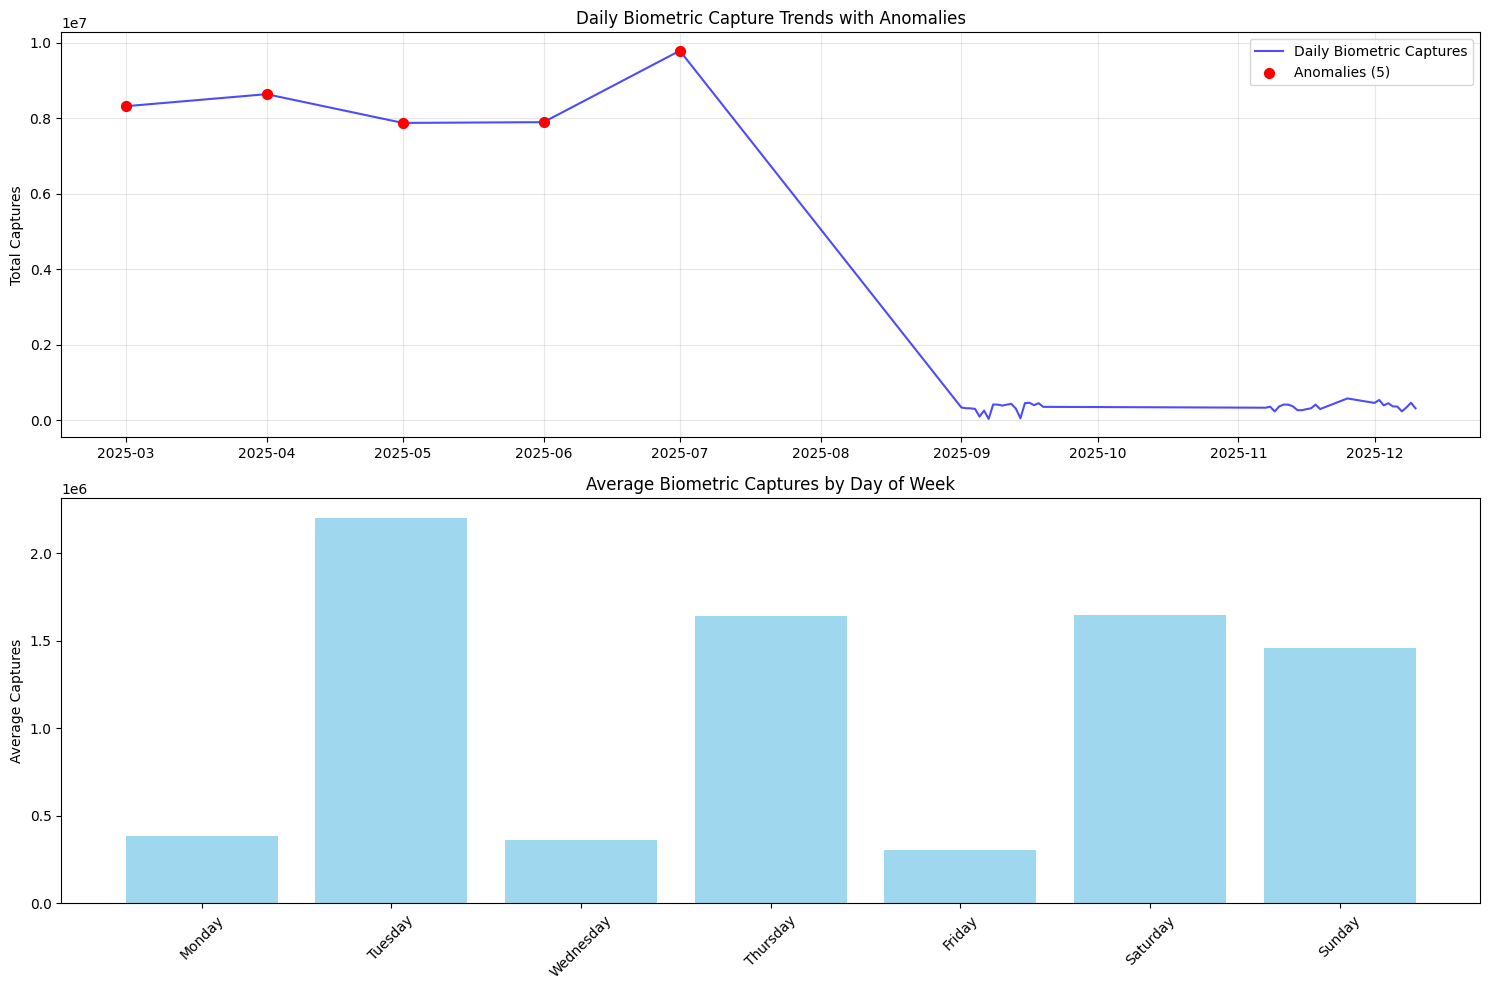


Top 5 Temporal Anomalies:
        date  total_bio  z_score
4 2025-07-01    9792552     3.43
1 2025-04-01    8641679     2.97
0 2025-03-01    8322222     2.84
3 2025-06-01    7899289     2.68
2 2025-05-01    7879956     2.67


In [3]:
# Daily biometric capture trends
daily_bio = bio_df.groupby('date').agg({
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()

daily_bio['total_bio'] = daily_bio['bio_age_5_17'] + daily_bio['bio_age_17_']
daily_bio['day_of_week'] = daily_bio['date'].dt.day_name()

# Detect temporal anomalies using Z-score
daily_bio['z_score'] = np.abs(stats.zscore(daily_bio['total_bio']))
temporal_anomalies = daily_bio[daily_bio['z_score'] > 2.5]

print(f"Temporal anomalies detected: {len(temporal_anomalies)}")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Daily trend with anomalies highlighted
ax1.plot(daily_bio['date'], daily_bio['total_bio'], color='blue', alpha=0.7, label='Daily Biometric Captures')
ax1.scatter(temporal_anomalies['date'], temporal_anomalies['total_bio'], 
           color='red', s=50, label=f'Anomalies ({len(temporal_anomalies)})', zorder=5)
ax1.set_title('Daily Biometric Capture Trends with Anomalies')
ax1.set_ylabel('Total Captures')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Day of week pattern
dow_pattern = daily_bio.groupby('day_of_week')['total_bio'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
ax2.bar(dow_pattern.index, dow_pattern.values, color='skyblue', alpha=0.8)
ax2.set_title('Average Biometric Captures by Day of Week')
ax2.set_ylabel('Average Captures')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if len(temporal_anomalies) > 0:
    print("\nTop 5 Temporal Anomalies:")
    print(temporal_anomalies.nlargest(5, 'z_score')[['date', 'total_bio', 'z_score']].round(2))

## 3. Geographic Failure Hotspots

Low-performing districts (bottom 10%): 96
Zero capture districts: 0


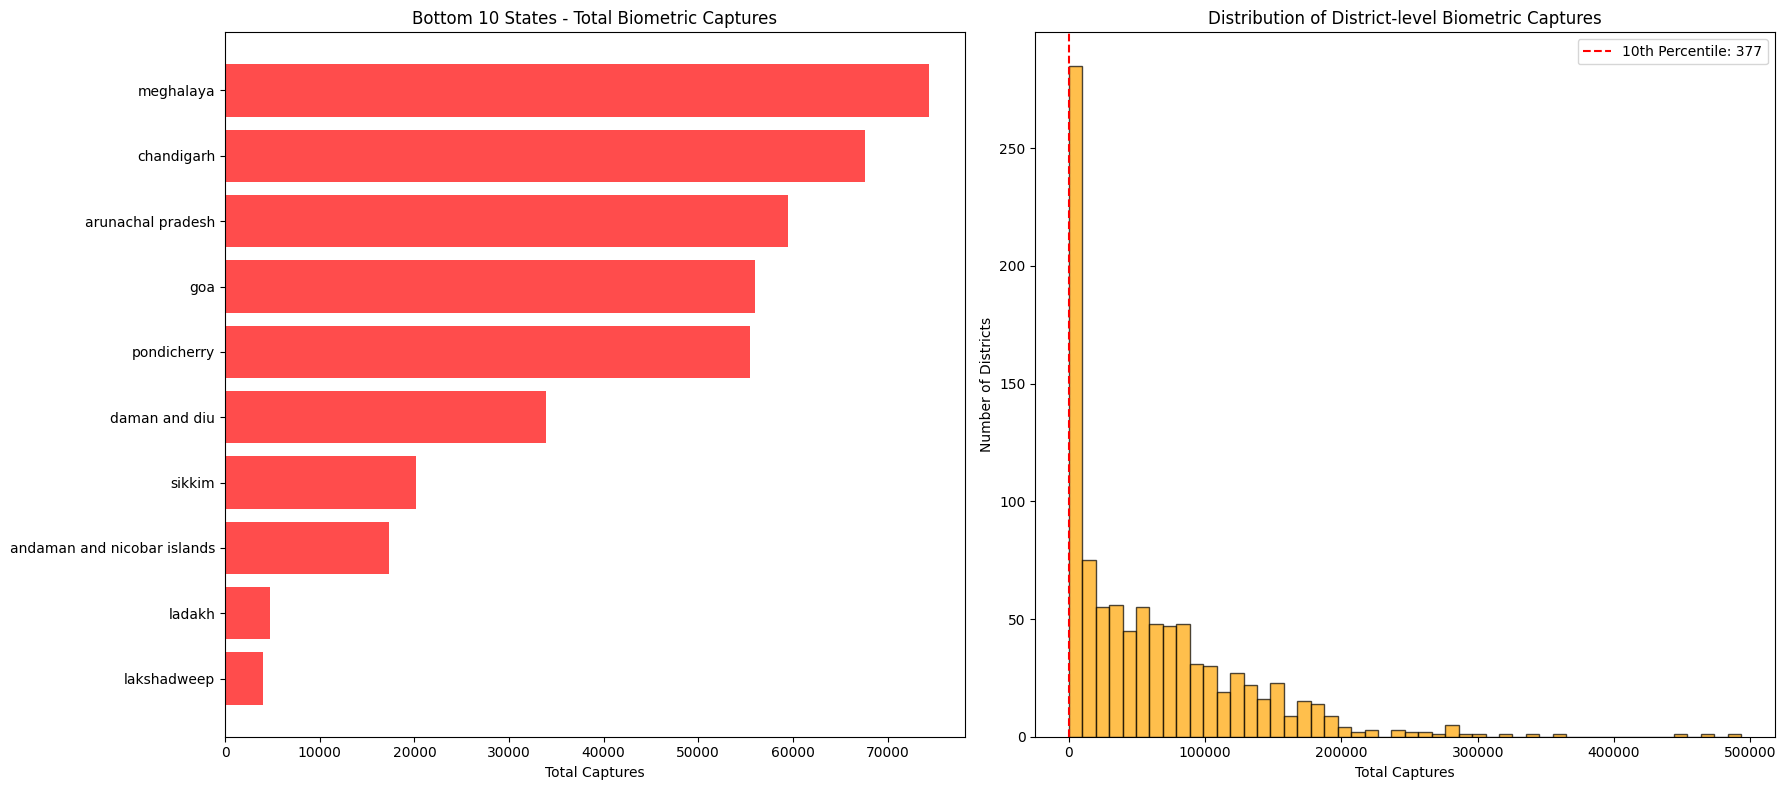


Bottom 10 States by Biometric Captures:
                          state  total_captures
18                  lakshadweep            3954
17                       ladakh            4719
0   andaman and nicobar islands           17349
29                       sikkim           20200
7                 daman and diu           33937
26                  pondicherry           55506
9                           goa           56014
2             arunachal pradesh           59520
5                    chandigarh           67643
22                    meghalaya           74411


In [4]:
# District-level analysis
district_bio = bio_df.groupby(['state', 'district']).agg({
    'bio_age_5_17': ['sum', 'mean'],
    'bio_age_17_': ['sum', 'mean']
}).reset_index()

# Flatten column names
district_bio.columns = ['state', 'district', 'bio_5_17_sum', 'bio_5_17_mean',
                       'bio_17_sum', 'bio_17_mean']

district_bio['total_captures'] = district_bio['bio_5_17_sum'] + district_bio['bio_17_sum']
district_bio['avg_daily_captures'] = district_bio['bio_5_17_mean'] + district_bio['bio_17_mean']

# Identify low-performing districts (bottom 10%)
low_threshold = district_bio['total_captures'].quantile(0.1)
low_performing = district_bio[district_bio['total_captures'] <= low_threshold]

# Zero capture districts
zero_capture = district_bio[district_bio['total_captures'] == 0]

print(f"Low-performing districts (bottom 10%): {len(low_performing)}")
print(f"Zero capture districts: {len(zero_capture)}")

# State-level performance
state_performance = district_bio.groupby('state').agg({
    'total_captures': 'sum',
    'avg_daily_captures': 'mean'
}).reset_index().sort_values('total_captures')

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Bottom 10 states
bottom_states = state_performance.head(10)
ax1.barh(bottom_states['state'], bottom_states['total_captures'], color='red', alpha=0.7)
ax1.set_title('Bottom 10 States - Total Biometric Captures')
ax1.set_xlabel('Total Captures')

# District distribution
ax2.hist(district_bio['total_captures'], bins=50, color='orange', alpha=0.7, edgecolor='black')
ax2.axvline(low_threshold, color='red', linestyle='--', label=f'10th Percentile: {low_threshold:.0f}')
ax2.set_title('Distribution of District-level Biometric Captures')
ax2.set_xlabel('Total Captures')
ax2.set_ylabel('Number of Districts')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nBottom 10 States by Biometric Captures:")
print(bottom_states[['state', 'total_captures']].round(0))

## 4. Equipment/Infrastructure Failure Detection

Locations with potential equipment issues: 0
Average consecutive zero days: 0.0
Locations with >50% zero capture rate: 0


/var/folders/b4/dpynylrs1fs7nt9mlwwk5g8w0000gn/T/ipykernel_84897/831911483.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  equipment_issues = bio_df_sorted.groupby(['state', 'district', 'pincode']).apply(find_consecutive_zeros).reset_index()


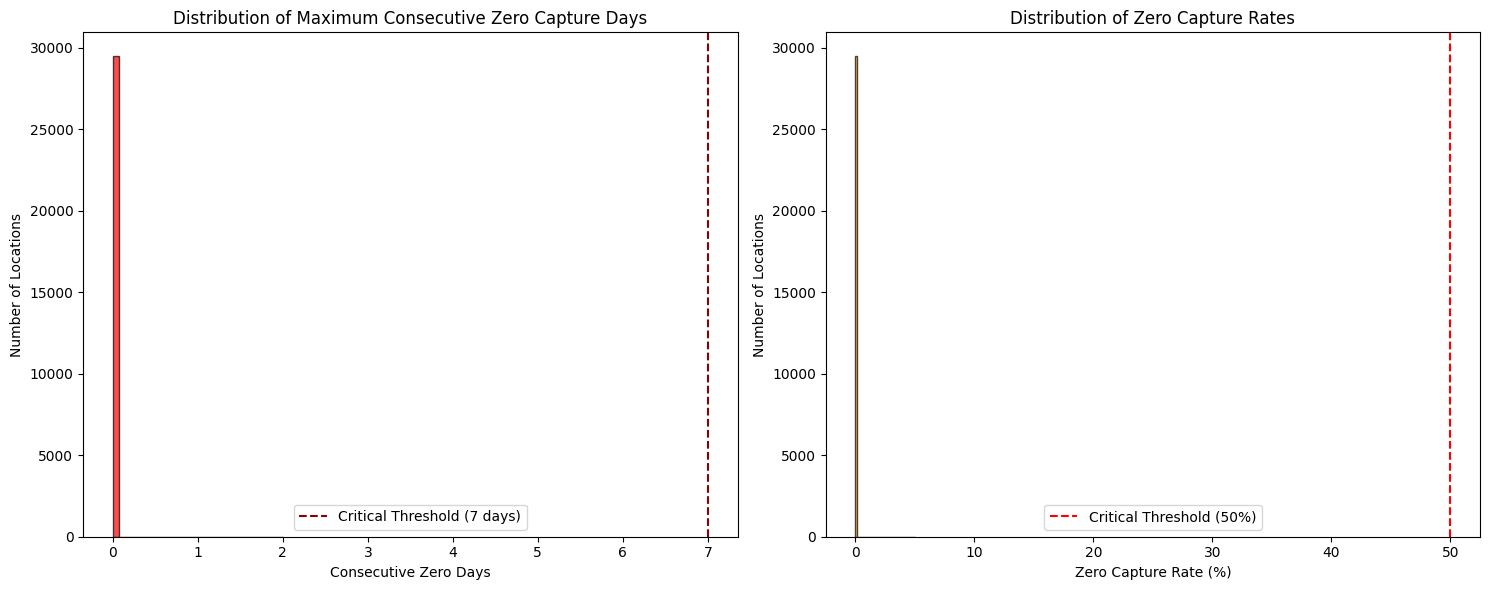

In [5]:
# Detect potential equipment failures (consecutive zero capture days)
bio_df_sorted = bio_df.sort_values(['state', 'district', 'pincode', 'date'])
bio_df_sorted['total_daily'] = bio_df_sorted['bio_age_5_17'] + bio_df_sorted['bio_age_17_']
bio_df_sorted['is_zero'] = (bio_df_sorted['total_daily'] == 0).astype(int)

# Find consecutive zero periods
def find_consecutive_zeros(group):
    max_consecutive = 0
    current_streak = 0
    
    for is_zero in group['is_zero']:
        if is_zero == 1:
            current_streak += 1
            max_consecutive = max(max_consecutive, current_streak)
        else:
            current_streak = 0
    
    return pd.Series({
        'max_consecutive_zeros': max_consecutive,
        'total_zero_days': group['is_zero'].sum(),
        'total_days': len(group)
    })

equipment_issues = bio_df_sorted.groupby(['state', 'district', 'pincode']).apply(find_consecutive_zeros).reset_index()
equipment_issues['zero_rate'] = (equipment_issues['total_zero_days'] / equipment_issues['total_days']) * 100

# Critical equipment issues (>7 consecutive zero days or >50% zero rate)
critical_equipment = equipment_issues[
    (equipment_issues['max_consecutive_zeros'] >= 7) | 
    (equipment_issues['zero_rate'] >= 50)
]

print(f"Locations with potential equipment issues: {len(critical_equipment)}")
print(f"Average consecutive zero days: {equipment_issues['max_consecutive_zeros'].mean():.1f}")
print(f"Locations with >50% zero capture rate: {(equipment_issues['zero_rate'] >= 50).sum()}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of consecutive zero days
ax1.hist(equipment_issues['max_consecutive_zeros'], bins=30, color='red', alpha=0.7, edgecolor='black')
ax1.axvline(7, color='darkred', linestyle='--', label='Critical Threshold (7 days)')
ax1.set_title('Distribution of Maximum Consecutive Zero Capture Days')
ax1.set_xlabel('Consecutive Zero Days')
ax1.set_ylabel('Number of Locations')
ax1.legend()

# Zero capture rate distribution
ax2.hist(equipment_issues['zero_rate'], bins=30, color='orange', alpha=0.7, edgecolor='black')
ax2.axvline(50, color='red', linestyle='--', label='Critical Threshold (50%)')
ax2.set_title('Distribution of Zero Capture Rates')
ax2.set_xlabel('Zero Capture Rate (%)')
ax2.set_ylabel('Number of Locations')
ax2.legend()

plt.tight_layout()
plt.show()

if len(critical_equipment) > 0:
    print("\nTop 10 Critical Equipment Issues:")
    print(critical_equipment.nlargest(10, 'max_consecutive_zeros')[['state', 'district', 'pincode', 'max_consecutive_zeros', 'zero_rate']].round(1))

## 5. Age Group Pattern Analysis

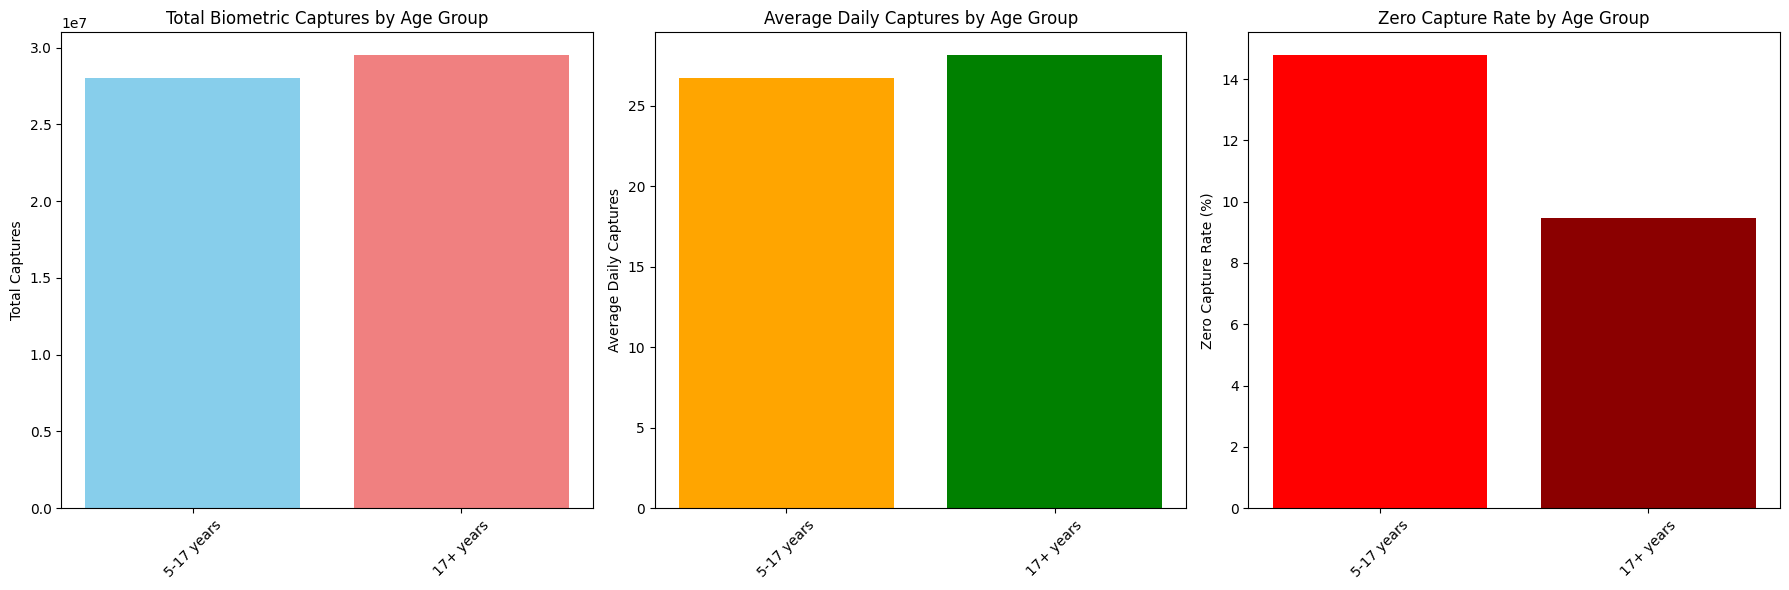

Age Group Analysis:
    Age_Group  Total_Captures  Avg_Daily_Captures  Zero_Capture_Days  \
0  5-17 years        28035502               26.74             155021   
1   17+ years        29514365               28.15              99367   

   Zero_Capture_Rate  
0              14.78  
1               9.48  


In [6]:
# Age group performance comparison
age_comparison = pd.DataFrame({
    'Age_Group': ['5-17 years', '17+ years'],
    'Total_Captures': [
        bio_df['bio_age_5_17'].sum(),
        bio_df['bio_age_17_'].sum()
    ],
    'Avg_Daily_Captures': [
        bio_df['bio_age_5_17'].mean(),
        bio_df['bio_age_17_'].mean()
    ],
    'Zero_Capture_Days': [
        (bio_df['bio_age_5_17'] == 0).sum(),
        (bio_df['bio_age_17_'] == 0).sum()
    ]
})

age_comparison['Zero_Capture_Rate'] = (age_comparison['Zero_Capture_Days'] / len(bio_df)) * 100

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Total captures by age group
ax1.bar(age_comparison['Age_Group'], age_comparison['Total_Captures'], 
        color=['skyblue', 'lightcoral'])
ax1.set_title('Total Biometric Captures by Age Group')
ax1.set_ylabel('Total Captures')
ax1.tick_params(axis='x', rotation=45)

# Average daily captures
ax2.bar(age_comparison['Age_Group'], age_comparison['Avg_Daily_Captures'], 
        color=['orange', 'green'])
ax2.set_title('Average Daily Captures by Age Group')
ax2.set_ylabel('Average Daily Captures')
ax2.tick_params(axis='x', rotation=45)

# Zero capture rate
ax3.bar(age_comparison['Age_Group'], age_comparison['Zero_Capture_Rate'], 
        color=['red', 'darkred'])
ax3.set_title('Zero Capture Rate by Age Group')
ax3.set_ylabel('Zero Capture Rate (%)')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Age Group Analysis:")
print(age_comparison.round(2))

## 6. Summary & Actionable Insights

In [7]:
# Generate comprehensive summary
summary_stats = {
    'Total Biometric Records': len(bio_df),
    'Total Captures (5-17)': bio_df['bio_age_5_17'].sum(),
    'Total Captures (17+)': bio_df['bio_age_17_'].sum(),
    'States Covered': bio_df['state'].nunique(),
    'Districts Covered': bio_df['district'].nunique(),
    'Temporal Anomalies': len(temporal_anomalies),
    'Low-Performing Districts': len(low_performing),
    'Zero Capture Districts': len(zero_capture),
    'Critical Equipment Issues': len(critical_equipment),
    'Avg Daily Captures': daily_bio['total_bio'].mean()
}

print("=" * 60)
print("BIOMETRIC FAILURE ANALYSIS SUMMARY (CORRECTED)")
print("=" * 60)

for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:,.1f}")
    else:
        print(f"{key}: {value:,}")

print("\n" + "=" * 60)
print("FAILURE CLASSIFICATION METHODOLOGY:")
print("=" * 60)
print("1. TEMPORAL FAILURES: Days with abnormal capture volumes (Z-score > 2.5)")
print("2. GEOGRAPHIC FAILURES: Districts in bottom 10% of capture performance")
print("3. EQUIPMENT FAILURES: Locations with 7+ consecutive zero days")
print("4. SYSTEMATIC FAILURES: Locations with >50% zero capture rate")
print("5. AGE-SPECIFIC ISSUES: Disproportionate failures in specific age groups")

print("\n" + "=" * 60)
print("ACTIONABLE RECOMMENDATIONS:")
print("=" * 60)
print("🔧 IMMEDIATE ACTIONS:")
print(f"   • Investigate {len(critical_equipment)} locations with equipment issues")
print(f"   • Deploy technical support to {len(zero_capture)} zero-capture districts")
print(f"   • Review {len(temporal_anomalies)} days with abnormal capture patterns")
print("\n📊 STRATEGIC ACTIONS:")
print(f"   • Capacity planning for {len(low_performing)} underperforming districts")
print("   • Age-specific intervention programs based on capture patterns")
print("   • Preventive maintenance scheduling for high-risk locations")
print("\n🎯 MONITORING PRIORITIES:")
print("   • Daily anomaly detection alerts")
print("   • Weekly equipment performance reviews")
print("   • Monthly district performance assessments")

BIOMETRIC FAILURE ANALYSIS SUMMARY (CORRECTED)
Total Biometric Records: 1,048,575
Total Captures (5-17): 28,035,502
Total Captures (17+): 29,514,365
States Covered: 36
Districts Covered: 937
Temporal Anomalies: 5
Low-Performing Districts: 96
Zero Capture Districts: 0
Critical Equipment Issues: 0
Avg Daily Captures: 1,198,955.6

FAILURE CLASSIFICATION METHODOLOGY:
1. TEMPORAL FAILURES: Days with abnormal capture volumes (Z-score > 2.5)
2. GEOGRAPHIC FAILURES: Districts in bottom 10% of capture performance
3. EQUIPMENT FAILURES: Locations with 7+ consecutive zero days
4. SYSTEMATIC FAILURES: Locations with >50% zero capture rate
5. AGE-SPECIFIC ISSUES: Disproportionate failures in specific age groups

ACTIONABLE RECOMMENDATIONS:
🔧 IMMEDIATE ACTIONS:
   • Investigate 0 locations with equipment issues
   • Deploy technical support to 0 zero-capture districts
   • Review 5 days with abnormal capture patterns

📊 STRATEGIC ACTIONS:
   • Capacity planning for 96 underperforming districts
   • 